In [19]:
import matplotlib.pyplot as plt
# import plumed
# import MDAnalysis
# import torch
import numpy as np
from scipy.stats import multivariate_normal
# import pandas as pd
# import raster_geometry as rg
!pwd


/home/yamin/Project/Proj23


In [5]:
#after using VMD save trajectories
filename = '../GpuLab/w_metadNa350_2/dump/pos_1'
df = np.loadtxt(filename, skiprows=2, usecols=[1,2,3], dtype=float)
# df = pd.read_csv(filename)
# df=df.T

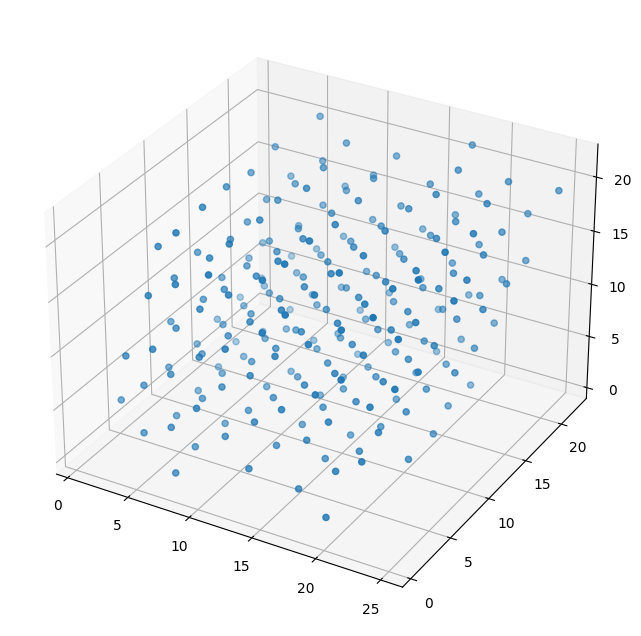

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(df[:,0],df[:,1],df[:,2])
plt.show()

In [45]:
df=df.T
length = np.ceil(df.max()) - np.floor(df.min())
arr = np.empty((3,250), float)
for i in range(3):
    for j in range(3):
        for k in range(3):
            arr = np.concatenate((arr,np.array((df[0]+(i*length),df[1]+(j*length),df[1]+(k*length)))),axis=1)
arr=arr.T[250::]


In [67]:
df

array([[ 9.463958, 18.513494,  7.306116],
       [ 8.439468, 10.586257,  2.604276],
       [20.121729, 19.243767, 14.375557],
       [21.287184, 11.978092, 15.282744],
       [ 1.140787, 18.091078,  3.842036],
       [12.994061, 11.116761, 11.151342],
       [13.238959, 18.748913,  3.038737],
       [ 5.803178,  3.109009,  7.964418],
       [16.144886,  4.832609, 17.607452],
       [19.544371,  8.842077, 12.97079 ],
       [17.314394,  5.463905, 10.477738],
       [21.508415, 14.057798, 11.198586],
       [23.428537, 12.668921, 20.506294],
       [21.84481 , 20.009266, 20.252676],
       [ 6.047698, 20.574766,  8.609923],
       [17.829092,  7.268772,  6.805969],
       [14.103289,  1.792337, 15.50979 ],
       [19.008575, 14.019733,  8.31995 ],
       [ 7.2407  ,  5.810244, 17.393524],
       [22.304916, 22.050896, 16.216799],
       [ 6.435778,  9.395305, 16.595465],
       [ 5.040262, 10.342875,  7.556019],
       [19.779251,  5.041419, 13.287675],
       [20.003187, 18.768538,  1.2

In [117]:
res = 5
x, y,z = np.mgrid[-1:1:5j, -1:1:5j,-1:1:5j]
pos = np.stack((x, y,z))
rv = multivariate_normal([0,0,0], [[1,0,0],[0,1,0],[0,0,1]])
a = rv.pdf(pos.T)


bin_num=30
l = 5
# m = np.zeros((bin_num+(2*l),bin_num+(2*l),bin_num+(2*l)))
m = np.zeros((3*bin_num,3*bin_num,3*bin_num))


coor = (arr*bin_num/length).astype(np.int_)
lim = np.arange(bin_num-int((l+1/2)),2*bin_num+int((l+1/2)))
for val in coor:
    if val[0]>lim[0] and val[0]<lim[-1] and val[1]>lim[0] and val[1]<lim[-1] and val[2]>lim[0] and val[2]<lim[-1]:
        m[val[0]-int(l/2):val[0]+int(l/2)+1, val[1]-int(l/2):val[1]+int(l/2)+1, 
          val[2]-int(l/2):val[2]+int(l/2)+1] += a



In [118]:
m[40,40,40]

0.05603293704580163

In [40]:
from scipy.stats import multivariate_normal
x = norm.pdf(np.arange(-1,1,0.1),0,1)
np.mgrid[-1:1:0.1,-1:1:0.1].shape

NameError: name 'norm' is not defined

In [43]:
res = 5
x, y,z = np.mgrid[-1:1:5j, -1:1:5j,-1:1:5j]
pos = np.stack((x, y,z))
rv = multivariate_normal([0,0,0], [[1,0,0],[0,1,0],[0,0,1]])
a = rv.pdf(pos.T)
# ax2 = fig2.add_subplot(111)
# ax2.contourf(x, y, rv.pdf(pos))
a.shape

(5, 5, 5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


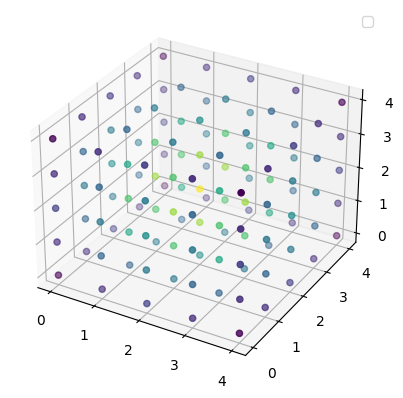

In [46]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
# M = np.random.rand(10, 10, 10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
counter = range(5)
x,y,z = np.meshgrid(counter, counter, counter)
ax.scatter(x,y,z, c=a.flat)
ax.legend()

plt.show()

In [38]:
res = 5
x, y,z = np.mgrid[-1:1:5j, -1:1:5j,-1:1:5j]
x

array([[[-1. , -1. , -1. , -1. , -1. ],
        [-1. , -1. , -1. , -1. , -1. ],
        [-1. , -1. , -1. , -1. , -1. ],
        [-1. , -1. , -1. , -1. , -1. ],
        [-1. , -1. , -1. , -1. , -1. ]],

       [[-0.5, -0.5, -0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5, -0.5, -0.5],
        [-0.5, -0.5, -0.5, -0.5, -0.5]],

       [[ 0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ]],

       [[ 0.5,  0.5,  0.5,  0.5,  0.5],
        [ 0.5,  0.5,  0.5,  0.5,  0.5],
        [ 0.5,  0.5,  0.5,  0.5,  0.5],
        [ 0.5,  0.5,  0.5,  0.5,  0.5],
        [ 0.5,  0.5,  0.5,  0.5,  0.5]],

       [[ 1. ,  1. ,  1. ,  1. ,  1. ],
        [ 1. ,  1. ,  1. ,  1. ,  1. ],
        [ 1. ,  1. ,  1. ,  1. ,  1. ],
        [ 1. ,  1. ,  1. ,  1. ,  1. ],
        [ 1. ,  1. ,  1. ,  1. ,

In [63]:
import raster_geometry as rg
rg.sphere(2*2, 2).astype(np.int_)

array([[[0, 0, 0, 0],
        [0, 1, 1, 0],
        [0, 1, 1, 0],
        [0, 0, 0, 0]],

       [[0, 1, 1, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [0, 1, 1, 0]],

       [[0, 1, 1, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [0, 1, 1, 0]],

       [[0, 0, 0, 0],
        [0, 1, 1, 0],
        [0, 1, 1, 0],
        [0, 0, 0, 0]]])

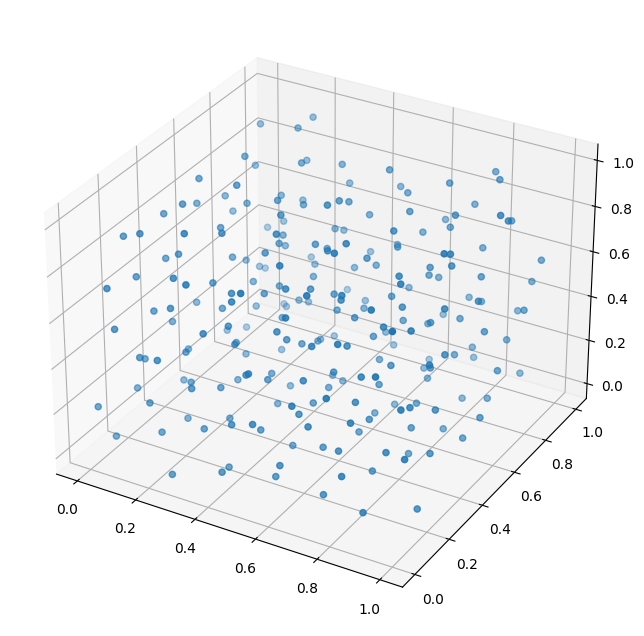

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(df.loc[:,2], df.loc[:,3], df.loc[:,4])
plt.show()

In [30]:
r = np.random.randn(100,3)
H, edges = np.histogramdd(r, bins = (5, 8, 4))
H.shape, edges[0].size, edges[1].size, edges[2].size


((5, 8, 4), 6, 9, 5)

In [ ]:
rep = "sphere"
sphere_r = 2
# class Positions:
#     def __init__(self, coordinates, bin_num, bin_start=0, bin_end=1, partition=1,rep=None,
#                  sphere_r=1,gau_mean=0,gau_std=1):


# if rep is not None:
#     vals = np.nonzero(H)
#     np.floor(repstd*bin_num)



# #l = shape/2
# def modulo_matrix_sum(p,M,L,a,l):

#     if p[0]-l < 0 || p[0]+l >= L || p[1]-l < 0 || p[1]+l >= L || p[2]-l < 0 || p[2]+l >= L:
#         Mlimits = [(np.mod(p[0]-l,L),np.mod(p[0]+l,L)),
#              (np.mod(p[1]-l,L),np.mod(p[1]+l,L)),(np.mod(p[2]-l,L),np.mod(p[2]+l,L))]
#         alimits = [(np.mod(p[0]-l,L),np.mod(p[0]+l,L)),
#              (np.mod(p[1]-l,L),np.mod(p[1]+l,L)),(np.mod(p[2]-l,L),np.mod(p[2]+l,L))]
#         Mranges = [[],[]]
#         aranges = [[],[]]
#         for x in Mlimits:
#             if x[0]>x[1]:
#                 Mranges[0].append(np.arange(0,x[1]))
#                 Mranges[1].append(np.arange(x[0],L))
#                 aranges[0].append(np.arange(,l))
#                 aranges[1].append(np.arange(0,))
#             else:
#                 Mranges[0].append(np.arange(x[0],x[1]))
#                 Mranges[1].append(np.arange(x[0],x[1]))
#                 Mranges[0].append(np.arange(0,l)
#                 Mranges[1].append(np.arange(0,l)
        
#         for r in ranges:
#             arr[r[0],r[1],r[2]] += a[] 

            
for i in range(pos.shape[0]):
    print(i)
    try:
        arr[coor[i,0]-sphere_r:coor[i,0]+sphere_r,
        coor[i,1]-sphere_r:coor[i,1]+sphere_r,
        coor[i,1]-sphere_r:coor[i,1]+sphere_r] += rg.sphere(sphere_r*2, sphere_r).astype(np.int_)
    except Exception:
        pass
coor